# Python Code Example:
# How to Tell Someone's Age If You Only Know Her Name

Recently, a friend of mine needed to contact someone named Mallory, but my friend was uncertain about Mallory's gender. However, the probability that someone named Mallory is female is about 98%; so it is probably safe to assume that Mallory is female.

This reminded me of a story that appeared on FiveThirtyEight.com in 2014 entitled <a href="https://fivethirtyeight.com/features/how-to-tell-someones-age-when-all-you-know-is-her-name/">How to Tell Someone's Age When All You Know Is Her Name</a>, and I thought that it might be interesting to re-create the FiveThirtyEight analysis in Python (<a href="https://twitter.com/jakevdp/status/1185044849428353027">everyone needs a hobby)</a>.  The article suggested that one might use the median age for a given name as a point estimate for age and also included plots of the median age for popular names, male and female, with bars showing the middle 50%.  We'll take those plots as a goal for this notebook.

I would like to highlight two key aspects of this analysis. First of all, the data are already aggregated so that one cannot compute the median age by name and gender by a simple application of the built-in methods. However, this provides an opportunity to discuss <b>GroupBy</b> objects in pandas. GroupBy objects are explained by Wes McKinney in Chapter 9, <i>Data Aggregation and Group Operations,</i> of <b>Python for Data Analysis.</b> McKinney notes that this type of computation is commonly referred to as "split-apply-combine", a phrase that was coined by Hadley Wickham, data science and R language guru. 

The second highlight is that the main data set has data about names given at birth, but we are interested in <i>living</i> Americans. So we need to join a dataset with survival rates to the name data. However, the survival rate data is given only for people born in years divisible by 10; so we need to <b>interpolate</b> the data. That's a good thing to know!

The Python code here does not re-create the FiveThirtyEight article in full, but it should get you to a point where you could easily re-create every graphic in the article.

## Initialization and Basic Data

We need to import pandas, numpy, and matplotlib.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

Go to the website https://www.ssa.gov/oact/babynames/limits.html and download the National data set. You should get a zipped archive file names.zip. Extract to the same directory as this script and it will create a directory (folder) called "names" with a bunch of text files with names like "yob2000.txt."  Using the UNIX utility "head", you can see that each file consists of rows with a name, sex, and the number of births for the given year. (The output shows in the IPYNB file, but fails to show in the HTML output.)

In [2]:
!ls names | tail -n 5

yob2015.txt
yob2016.txt
yob2017.txt
yob2018.txt
yob2019.txt


In [3]:
!head -n 5 names/yob2000.txt

We want to run through all of the text files, reading them into their own dataframes, adding a column to identify the year,  and then concatenating them into one big dataframe.  Although the data goes back to 1880, we do not need to load data prior to 1900. You could do this with a for-loop, but a list comprehension is more "Pythonic!"

The <tt>sample</tt> function is an alternative to <tt>head</tt> for inspecting your dataset.

In [4]:
def year2frame(year):
    path = f'names/yob{year:4d}.txt'
    frame = pd.read_csv(path,names=['name','sex','births'])
    frame['year']=year
    return frame

df_names = pd.concat([year2frame(year) for year in range(1900,2020)]) 

In [5]:
df_names.sample(5)

,name,sex,births,year
31372,Humphrey,M,5,2017
25089,Aijalon,M,8,2000
12307,Shariff,M,14,1971
14169,Demarko,M,16,1978
3452,Dorcas,F,31,1990


One thing to note about the data is that a name-sex pair is included for a given year only if there were at least five births for that name-sex pair.

Let's define a function that takes name and sex and plots the number of births by year. 

In [6]:
def plot_births_by_name(name,gender):
    # Define mappings for colors and text annotations.
    my_gender={'M':'Boys','F':'Girls'}
    my_color={'M':'skyblue','F':'pink'}
    # This creates a filled graph
    plt.fill_between(df_names[(df_names.name==name) & (df_names.sex==gender)].year,
                     df_names[(df_names.name==name) & (df_names.sex==gender)].births,
                     color=my_color[gender],alpha=0.6);
    # This puts a nice border ont he filled portion of the graph.
    plt.plot(df_names[(df_names.name==name) & (df_names.sex==gender)].year,
             df_names[(df_names.name==name) & (df_names.sex==gender)].births,
             color=my_color[gender]);
    # Add labels and title
    plt.ylabel('Number of Births')
    plt.xlabel('Year of Birth')
    # Note the use of an f-string here with the mapping from M/F to Boys/Girls.
    plt.title(f'{my_gender[gender]} Named {name}')

Consider the distributions for Mallory by gender. Note the subplots have very different vertical scales. Many more girls than boys were named Mallory (about 100x), and there was a big uptick in the number of girls names Mallory after 1980. (Was there a celebrity or a movie character named Mallory in the early 1980s?)  My friend is in his mid-70s, and his children were born before the 1980. So maybe he doesn't know many Mallories!

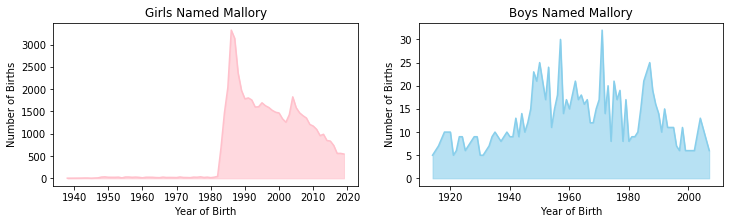

In [7]:
plt.subplots(1,2,figsize=(12,3))
plt.subplot(121)
plot_births_by_name('Mallory','F')
plt.subplot(122)
plot_births_by_name('Mallory','M')

## Actuarial Tables

As I noted above, we are interested in the number of living Americans. Before we add in survival rates, let's look at the name data more closely. First, consider the number of births in total and then the number of births by sex and year.  For the latter, we can apply <tt>groupby</tt> in a straight forward way.

In [8]:
df_names.births.sum()

349379285

In [9]:
df_births_by_sex = df_names.groupby(['year','sex']).births.sum().reset_index()

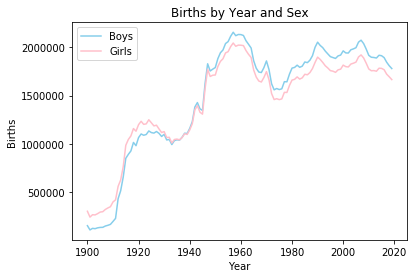

In [10]:
plt.plot(df_births_by_sex[df_births_by_sex.sex=='M'].year,
        df_births_by_sex[df_births_by_sex.sex=='M'].births,
        color='skyblue');
plt.plot(df_births_by_sex[df_births_by_sex.sex=='F'].year,
        df_births_by_sex[df_births_by_sex.sex=='F'].births,
        color='pink');
plt.legend(['Boys','Girls']);
plt.ylabel('Births');
plt.xlabel('Year');
plt.title('Births by Year and Sex');

Why do there seem to be fewer girl births than boy births from 1950 onward? As noted above, the data only includes baby names that appear five times or more per year; so children with rare names "leak out" of the dataset.  There also happens to be a greater diversity of girl names in the dataset; i.e. about one-third more girls names than boys names per year. So it seems likely that there are more women than men who are missing from the data set and not the case that there are more men.

Let's turn now to the survival rates. Life expectancy in the US today is just under 80 years and has increased through most of history.  The SSA has detailed <a href="https://www.ssa.gov/oact/NOTES/as120/LifeTables_Tbl_7.html">actuarial tables</a> publishing approximate year-by-year death rates and survival rates by sex for people born in years at decade intervals starting in 1900. These are based on historical records and include projections into the future.

I thought that I would have to process these tables line-by-line with a <tt>readlines()</tt> command, but on the SSA site you have to click through a series of tables. We need only two numbers from each of the thirteen tables. Specifically, to get survivors in 2019 per 100,000 births in year $y$, read the value in columns $l_x$ for each gender from the line corresponding to the age (2019 - $y$). It was easier to write these down by hand and enter the data into an Excel spreadsheet, and I named it "LifeTable.xlsx".

To get the survival rates for people born in years not divisible by 10, we will interpolate.

In [11]:
df_life_table = pd.read_excel("LifeTable.xlsx")

In [12]:
df_life_table

,year,sex,survival
0,1880,M,0
1,1890,M,0
2,1900,M,0
3,1910,M,1
4,1920,M,499
5,1930,M,13234
6,1940,M,44969
7,1950,M,70262
8,1960,M,83535
9,1970,M,90745


We need to fill this table in with all years; so we generate a dataframe <tt>df_temp</tt> listing all dates from 1900 to 2020 for both sexes. We will use an outer join to merge this with <tt>df_life_table</tt>.  This will create a bunch of rows with missing values but <tt>interpolate</tt> will fill them in.

In [13]:
df_temp = pd.DataFrame({'year':list(range(1900,2021))*2,'sex':['M']*121 + ['F']*121})

In [14]:
df_life_table_expanded = df_life_table.merge(df_temp, on=['year','sex'], how='outer').sort_values(by=['sex','year'])

In [15]:
df_life_table_expanded.tail(21)

,year,sex,survival
12,2000,M,98655.0
120,2001,M,NaN
121,2002,M,NaN
122,2003,M,NaN
123,2004,M,NaN
124,2005,M,NaN
125,2006,M,NaN
126,2007,M,NaN
127,2008,M,NaN
128,2009,M,NaN


We subset the dataframe by rows and columns using sex and the column 'survival'.  Using the Series method <tt>interpolate</tt> to fill in the missing values. At the same time, we reduce the column 'survival' to a rate by dividing through by 100,000. The default interpolation is linear; see the <a href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.interpolate.html">documentation for other methods.</a>

In [16]:
for g in df_life_table_expanded.sex.unique():
    df_life_table_expanded.loc[df_life_table_expanded.sex==g,'survival'] = \
    df_life_table_expanded[df_life_table_expanded.sex==g].survival.interpolate()/100000

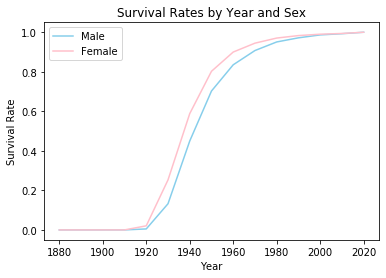

In [17]:
# Plot the survival curve for males.
plt.plot(df_life_table_expanded[df_life_table_expanded.sex=='M'].year, 
         df_life_table_expanded[df_life_table_expanded.sex=='M'].survival,
         color='skyblue');
# Plot the survical curve for females.
plt.plot(df_life_table_expanded[df_life_table_expanded.sex=='F'].year, 
         df_life_table_expanded[df_life_table_expanded.sex=='F'].survival,
         color='pink');
# Add labels, title, and legend.
plt.title('Survival Rates by Year and Sex');
plt.legend(['Male','Female']);
plt.xlabel('Year');
plt.ylabel('Survival Rate');

Now we can join the survival rates to the birth data to get an approximate number of <b>living</b> people with a given name by sex and year of birth. Now, when we plot the births by year and compare it to the number of living people, we see the effects of the actuarial survival rates.

In [18]:
df_names_living = df_names.merge(df_life_table_expanded, on=['year','sex'])

In [19]:
df_names_living['living'] = df_names_living.births*df_names_living.survival
df_names_living['age'] = 2019 - df_names_living.year

In [20]:
def plot_living_vs_births(name='Anna',sex='F'):
    # Mappings, same as above.
    my_color = {'M':'skyblue','F':'pink'}
    my_gender = {'M':'Boys','F':'Girls'}
    # Create a filled plot for surviving people.
    plt.fill_between(df_names_living[(df_names_living.name==name) & (df_names_living.sex==sex)].year,
                     df_names_living[(df_names_living.name==name) & (df_names_living.sex==sex)].living,
                     color=my_color[sex],alpha=0.7);
    # Create a line plot for births. This eill be higher than the boundary of the survivors.
    plt.plot(df_names_living[(df_names_living.name==name) & (df_names_living.sex==sex)].year, 
             df_names_living[(df_names_living.name==name) & (df_names_living.sex==sex)].births,
             color=my_color[sex]);
    # Add title, legend and label.
    plt.title(f'{my_gender[sex]} Named {name}: Births vs Survivors in 2019');
    plt.legend(['Surviving','Births']);
    plt.xlabel('Year');

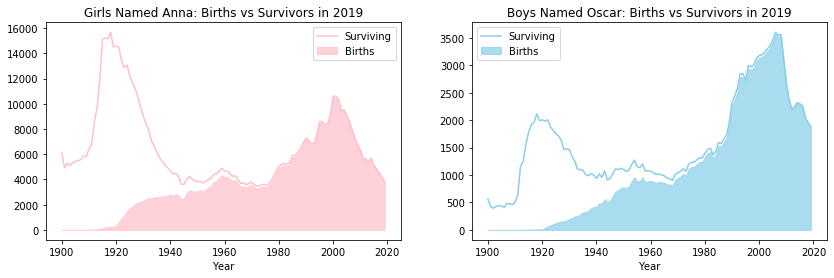

In [21]:
plt.subplots(1,2,figsize=(14,4))
plt.subplot(121)
plot_living_vs_births(name='Anna',sex='F')
plt.subplot(122)
plot_living_vs_births(name='Oscar',sex='M')

## How to Tell Someone's Age If You Only Know Her Name

As mentioned above, FiveThirtyEight used the median age as a point estimate for estimating someone's age based on the name and gender. Of course alternate point estimates would include the mean and mode. Of these, the mode (or maximum likelihood estimate) is the easiest to obtain. Since the data has already been aggregated at the level of year-of-birth, we cannot simply use the available methods for mean and median. We need to compute, for each name and sex, the proportion of living people born in a given year first and use that as a probability density for computing the standard statistics.

Let's use the name Brittney as an example.

We start by create a copy of the subset of the dataframe df_names_living. We use <tt>.copy()</tt> or we would end up with a "view" of a subset of the original dataframe, and attempting to manipulate a view causes the <a href="https://www.dataquest.io/blog/settingwithcopywarning/">SettingWithCopyWarning.</a>

In [22]:
df_brittney = df_names_living[(df_names_living.name=="Brittney")&(df_names_living.sex=="F")].copy()
df_brittney['prob'] = df_brittney.living/df_brittney.living.sum()

Here is the probability distribution for women named Brittney. By construction the pink-shaded area is 1. Note that we have changed from looking at the distribution by age as opposed to year of birth. 

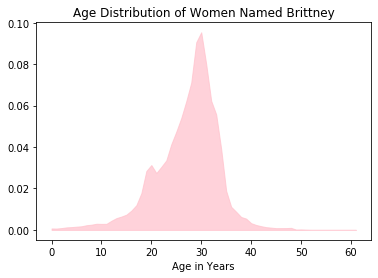

In [23]:
plt.fill_between(df_brittney.age, df_brittney.prob, color='pink',alpha=0.7);
plt.title(f'Age Distribution of Women Named Brittney');
plt.xlabel('Age in Years');

So given the probability distribution, in the following cell we compute the mean and the median ages. The mean is the expected value of age. The median is the least age for which the cumulative probability greater than or equal to 0.5.  Given the mean and median, one can compute their correspondin measures of dispersion: mean squared error and mean absolute deviation. 

In [24]:
df_brittney.sort_values(by='age',inplace=True)
mode = df_brittney.age[df_brittney.living.idxmax()]
mean = (df_brittney.prob*df_brittney.age).sum()
median = df_brittney.age[df_brittney.prob.cumsum() >= 0.5].min()
print(f'The mean, median, and mode of age are {mean:.2f}, {median}, and {mode}, respectively.')

The mean, median, and mode of age are 27.17, 28, and 30, respectively.


These three numbers differ slightly from one another, but they make sense given the shape of the distribution and what we intuitively know about mean, median, and mode. 

To perform this computation on every subset of data (i.e. for each name and sex) pandas has the <tt>groupby</tt> method which returns a GroupBy object. GroupBy objects have their own methods, including one that will apply arbitrary functions to  transform or aggregate the data group-by-group. The built-in GroupBy methods like sum and count are fast, but custom written GroupBy functions tend to be a bit slow.  Follow the link for more info on <a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html">GroupBy</a>. 

We start by sorting the data to make it increasing in age for each name and sex.  Next we define the function <tt>get_probs</tt> which we want to apply to each of the groups to compute the probability and cumulative probability of the distribution by age. The combination of the methods <tt>groupby</tt> and <tt>apply</tt> performs the "split-apply-combine" mentioned above (there is an implicit concatenation).  In this case we are add two columns to the group and <tt>return</tt> the altered group; so after the application of the groupby-apply, we have added two columns to df_names_living.

I sometimes insert the "magic" function <tt>%time</tt> in my code when there are certain methods that are slow. It helps me to know which cells I want to avoid re-running and how much time I have to go get coffee. (I ran this at home on my personal laptop which is about 10x slower than my work machine.)

In [25]:
df_names_living.sort_values(by=['name','sex','age'],ascending=True, inplace=True)

In [26]:
def get_probs(group):
    group['prob'] = group.living/group.living.sum()
    group['cum_prob'] = group.living.cumsum()/group.living.sum()
    return group

In [27]:
# This takes about 21 minutes on my 2016 vintage MacBook Pro.
%time df_names_living = df_names_living.groupby(['name','sex']).apply(get_probs)

CPU times: user 21min 9s, sys: 6.64 s, total: 21min 15s
Wall time: 46min 7s


Note that the <tt>groupby</tt> method can be used alone as well as in combination with other functions. It can be quite useful to work with GroupBy objects directly rather than always applying a function to them.  Consider the object <tt>grouped</tt> and the method <tt>get_group</tt>.

In [28]:
grouped = df_names_living.groupby(['name','sex'])

In [29]:
grouped.get_group(('Mallory','F')).head(10)

,name,sex,births,year,survival,living,age,prob,cum_prob
1905734,Mallory,F,546,2019,0.999379,545.660934,0,0.010058,0.010058
1873569,Mallory,F,561,2018,0.998758,560.303238,1,0.010327,0.020385
1840942,Mallory,F,560,2017,0.998137,558.956720,2,0.010303,0.030688
1807798,Mallory,F,738,2016,0.997516,736.166808,3,0.013569,0.044256
1774616,Mallory,F,837,2015,0.996895,834.401115,4,0.015380,0.059636
1741342,Mallory,F,850,2014,0.996274,846.832900,5,0.015609,0.075245
1707990,Mallory,F,989,2013,0.995653,984.700817,6,0.018150,0.093395
1674231,Mallory,F,959,2012,0.995032,954.235688,7,0.017588,0.110983
1640280,Mallory,F,1098,2011,0.994411,1091.863278,8,0.020125,0.131108
1606189,Mallory,F,1173,2010,0.993790,1165.715670,9,0.021486,0.152594


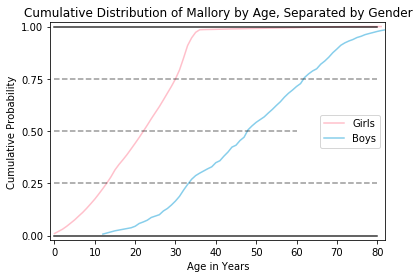

In [30]:
def plot_cum_prob_by_name_sex(name,sex):
    my_color = {'M':'skyblue','F':'pink'}
    plt.plot(grouped.get_group((name,sex)).age,
             grouped.get_group((name,sex)).cum_prob,
             color=my_color[sex]);

# Plot cumulative probabiliy curves by gender
plot_cum_prob_by_name_sex('Mallory','F')
plot_cum_prob_by_name_sex('Mallory','M')

# Add some horizontal lines for reference to quartile scores.
plt.plot([0,60],[0.5,0.5],'--k',alpha=0.4);
plt.plot([0,80],[0.25,0.25],'--k',alpha=0.4);
plt.plot([0,80],[0.75,0.75],'--k',alpha=0.4);
plt.plot([0,80],[1,1],'-k', alpha=0.8);
plt.plot([0,80],[0,0],'-k', alpha=0.8);
plt.axis([-1,82,-0.02,1.02])

# Add legend, title, yticks, and labels.
plt.legend(['Girls','Boys'],loc='right');
plt.title("Cumulative Distribution of Mallory by Age, Separated by Gender");
plt.ylabel("Cumulative Probability");
plt.xlabel("Age in Years");
plt.yticks([0,.25,.5,.75,1]);

Like the FiveThirtyEight analysis, we would like to compute the three quartile scores by group. 

The following is somewhat inelegant (perhaps even <a href="https://www.merriam-webster.com/dictionary/kludge">kludgy</a>) --- I thought that I could follow an example in McKinney or use <a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#named-aggregation">named aggregation,</a> but I couldn't get it to work the that way I expected. So I wrote one function that returns the three quartile scores in a dict with the keys 'q1', 'q2', and 'q3'. The groupby-apply returns a single, dict-valued series. To this series I passed each of the three dict keys using <tt>apply</tt> which is a series method in this context. This generates three new, separate series which we concatenated as the columns of the dataframe df_names_quartiles. The columns are automatically labeled 0, 1 and 2, but they can be renamed more appropriately. (Note that I use the %time function again.)

In [31]:
def group_quartiles(group):
    return {'q1':group.age[group.cum_prob >= 0.25].min(),
            'q2':group.age[group.cum_prob >= 0.5].min(),
            'q3':group.age[group.cum_prob >= 0.75].min()}

In [32]:
# This takes about 3 minutes.
%time df_name_quartiles_dict = grouped.apply(group_quartiles)

CPU times: user 2min 48s, sys: 4.43 s, total: 2min 53s
Wall time: 2min 50s


In [33]:
df_name_quartiles_dict.sample(5)

name      sex
Jaylahni  F         {'q1': 1, 'q2': 1, 'q3': 1}
Riddhish  M         {'q1': 3, 'q2': 3, 'q3': 3}
Ante      M      {'q1': 18, 'q2': 31, 'q3': 40}
Semajay   M       {'q1': 7, 'q2': 11, 'q3': 13}
Katera    F      {'q1': 18, 'q2': 21, 'q3': 25}
dtype: object

In [34]:
df_name_quartiles = pd.concat([df_name_quartiles_dict.apply(lambda x: x['q1']), 
           df_name_quartiles_dict.apply(lambda x: x['q2']), 
           df_name_quartiles_dict.apply(lambda x: x['q3'])],
          axis=1).rename(columns={0:'q1',1:'median',2:'q3'})

In [35]:
df_name_quartiles.sample(5)

,,q1,median,q3
name,sex,,,
Charlotta,F,45.0,54.0,67.0
Yaidden,M,4.0,4.0,4.0
Rechelle,F,32.0,43.0,50.0
Melana,F,13.0,20.0,39.0
Rhylan,M,2.0,5.0,8.0


The cell below does the same thing as above, but here we define <i>three</i> group functions, apply them separately, and then concatenate the results.  It's a little easier to follow what's going on, but it's also slower. It's a "raw" cell and not executable.

The FiveThirtyEight analysis plotted bars for the quartile scores for the 25 most popular names for living men and women. So we need to find the 25 most popular names.  Let's continue using the GroupBy object <tt>grouped</tt>, sum over the number of living Americans and sort by gender from highest to lowest. Once we have that data, we take subsets of the 25 top male names and join this to the data frame <tt>df_name_quartiles</tt>. Then repeat this for the top 25 female names.

In [36]:
df_popularity = grouped.living.sum().reset_index().sort_values(by=['sex','living'], ascending=[True,False])

In [37]:
#Use .loc(row_spec,column_spec) to subset df_names_quartiles.
df_men25 = df_name_quartiles.loc[([name for name in df_popularity[df_popularity.sex=='M'][:25].name],'M'),:].copy()

In [38]:
df_men25.sort_values(by='median',ascending=False,inplace=True)

In [39]:
# the top 25 men's names from oldest to youngest by median age
df_men25

,,q1,median,q3
name,sex,,,
Richard,M,45.0,59.0,69.0
Robert,M,41.0,57.0,68.0
Charles,M,37.0,57.0,69.0
John,M,38.0,55.0,67.0
James,M,37.0,55.0,67.0
Paul,M,41.0,55.0,65.0
Mark,M,42.0,54.0,60.0
Thomas,M,34.0,54.0,66.0
William,M,30.0,53.0,67.0


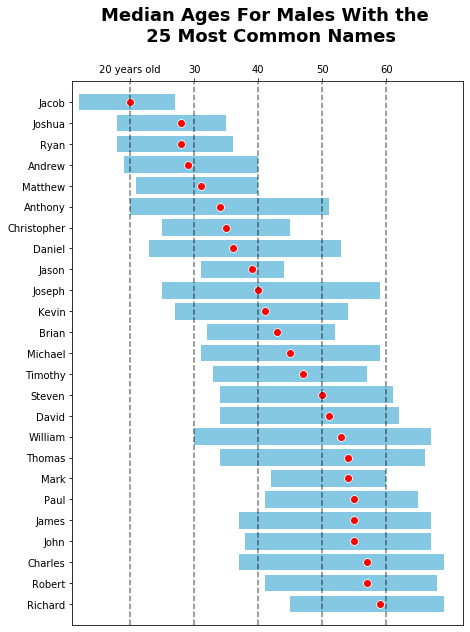

In [40]:
# Plot this with horizontal bars using an aquamarine color.
fig=plt.figure(figsize=(7,10));

# We want to use the axes handle later, but it seems odd to define subplot(111).
ax = fig.add_subplot(111);
r = range(1,26)
barWidth = 1

# The keyword option "left=" is for stacked bars. There is no bar on the right,
# but "left" indicates where the left-hand edge lies for "second" bar.
# The hex code #66bbdd is roughly aquamarine and was derived by trial and error.
plt.barh(r, df_men25.q3-df_men25.q1, left=df_men25.q1,color='#66bbdd',alpha=0.8);

# FiveThirtyEight marks the median with a large red dot which appears to have a white outline.
# There might be a better way to do this than drawing a red dot on top of a larger white dot.
plt.plot(df_men25['median'],r,'.w', markersize=15);
plt.plot(df_men25['median'],r,'.r', markersize=12);

# Draw some vertical lines for easier comparisons.
plt.plot([20,20],[0,26],'--k',alpha=0.5);
plt.plot([30,30],[0,26],'--k',alpha=0.5);
plt.plot([40,40],[0,26],'--k',alpha=0.5);
plt.plot([50,50],[0,26],'--k',alpha=0.5);
plt.plot([60,60],[0,26],'--k',alpha=0.5);

# Here's where we put the xticks on the top of the plot.
ax.xaxis.tick_top()
plt.xticks(range(20,70,10),['20 years old',30,40,50,60],);

# Use the names as labels for the yticks.
plt.yticks(r,list(df_men25.index.get_level_values(0)));

# This makes the bounding box a little tidier.
plt.axis([11,72,0,26]);

# We need to add a pad of 40 points to keep the title from overlaying the xticks.
plt.title('Median Ages For Males With the \n 25 Most Common Names',
          fontweight='bold', fontsize=18, pad=40);

Now we repeat this process for the women.

In [41]:
df_women25 = df_name_quartiles.loc[([name for name in df_popularity[df_popularity.sex=='F'][:25].name],'F'),:].copy()

In [42]:
df_women25.sort_values(by='median',ascending=False, inplace=True)

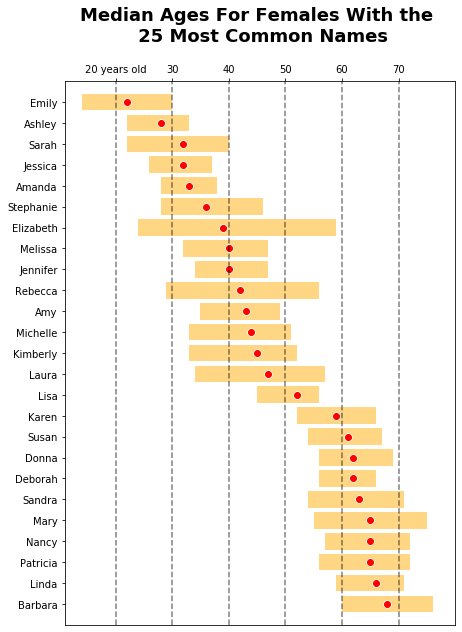

In [43]:
# Plot this with horizontal bars using an goldenrod color.
fig=plt.figure(figsize=(7,10));

# We want to use the axes handle later, but it seems odd to define subplot(111).
ax = fig.add_subplot(111);
r = range(1,26)
barWidth = 1

# The keyword option "left=" is for stacked bars. There is no bar on the right,
# but "left" indicates where the left-hand edge lies for "second" bar.
# The hex code #ffbb33 is roughly goldenrod and was also derived by trial and error.
plt.barh(r, df_women25.q3-df_women25.q1, left=df_women25.q1,color='#ffbb33',alpha=0.6);

# FiveThirtyEight marks the median with a large red dot which appears to have a white outline.
# There might be a better way to do this than drawing a red dot on top of a larger white dot.
plt.plot(df_women25['median'],r,'.w', markersize=15);
plt.plot(df_women25['median'],r,'.r', markersize=12);

# Draw some vertical lines for easier comparisons.
plt.plot([20,20],[0,26],'--k',alpha=0.5);
plt.plot([30,30],[0,26],'--k',alpha=0.5);
plt.plot([40,40],[0,26],'--k',alpha=0.5);
plt.plot([50,50],[0,26],'--k',alpha=0.5);
plt.plot([60,60],[0,26],'--k',alpha=0.5);
plt.plot([70,70],[0,26],'--k',alpha=0.5);

# Here's where we put the xticks on the top of the plot.
ax.xaxis.tick_top()
plt.xticks(range(20,80,10),['20 years old',30,40,50,60,70],);

# Use the names as labels for the yticks.
plt.yticks(r,list(df_women25.index.get_level_values(0)));

# This makes the bounding box a little tidier.
plt.axis([11,80,0,26]);

# We need to add a pad of 40 points to keep the title from overlaying the xticks.
plt.title('Median Ages For Females With the \n 25 Most Common Names',
          fontweight='bold', fontsize=18, pad=40);

It's interesting to simply compare the list of the 25 most popular names for men and women in 2019 versus the list 2014 in the original article.  Four of the seven "oldest" names in the top 25 for men in 2014 do not appear in the list of the top 25 names in 2019. Similarly, seven of the eight oldest women's names in the top 25 in 2014 do not repeat in 2018. 

Beyond these two plots, the article on FiveThirtyEight examines some names that have large interquartile ranges. In 2014, the name with the greatest interquartile range was Anna. However, Anna failed to make the top 25 female names in 2019; the distribution was highly bi-modal with the number of surviving Annas from the 1920 much diminished. In 2019 Elizabeth was the only female name with an interquartile range (IQR) over 30. There are seven male names with IQR over 30 years. Many of the names with large IQR are names that were once very popular and have remained somewhat popular but are declining. A few names, like Rebecca, have had sustained popularity for multiple generations. On the other hand, the distribution of ages for names like Amanda and Jason have relatively narrow ranges.

FiveThirtyEight produces some additional plots for the "youngest" and "oldest" male and female names. However, they stick to the most popular names by restricting the dataset to names given to a minimum of 100,000 Americans of one gender. In 2019 that would leave just 502 names in the dataset.  I will leave that as an exercise for the reader as well.

The remaining cells in this notebook compute the interquartile ranges, sort from largest to smallest, and then produce some plots of distributions of year of birth for the widest and narrowest ranges.  Also, a plot showing distributions for Leslie, a name that was once more common for men than women but now is more common among women. You can search for your own examples of names that have migrated from one gender to the other --- typically, if not exclusively, male to female.

In [44]:
df_men25['iqr'] = df_men25.q3 - df_men25.q1
df_men25.sort_values(by='iqr',ascending=False)

,,q1,median,q3,iqr
name,sex,,,,
William,M,30.0,53.0,67.0,37.0
Joseph,M,25.0,40.0,59.0,34.0
Charles,M,37.0,57.0,69.0,32.0
Thomas,M,34.0,54.0,66.0,32.0
Anthony,M,20.0,34.0,51.0,31.0
James,M,37.0,55.0,67.0,30.0
Daniel,M,23.0,36.0,53.0,30.0
John,M,38.0,55.0,67.0,29.0
Michael,M,31.0,45.0,59.0,28.0


In [45]:
df_women25['iqr'] = df_women25.q3 - df_women25.q1
df_women25.sort_values(by='iqr',ascending=False)

,,q1,median,q3,iqr
name,sex,,,,
Elizabeth,F,24.0,39.0,59.0,35.0
Rebecca,F,29.0,42.0,56.0,27.0
Laura,F,34.0,47.0,57.0,23.0
Mary,F,55.0,65.0,75.0,20.0
Kimberly,F,33.0,45.0,52.0,19.0
Sarah,F,22.0,32.0,40.0,18.0
Stephanie,F,28.0,36.0,46.0,18.0
Michelle,F,33.0,44.0,51.0,18.0
Sandra,F,54.0,63.0,71.0,17.0


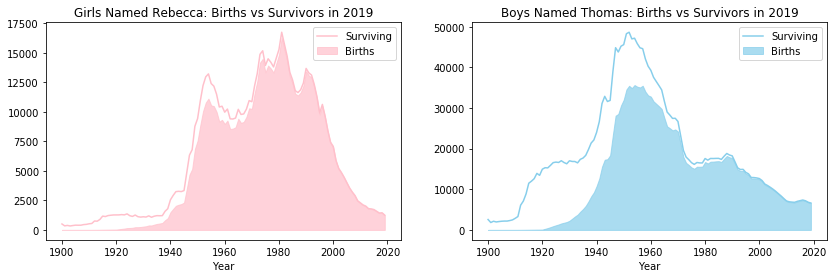

In [46]:
plt.subplots(1,2,figsize=(14,4))
plt.subplot(121)
plot_living_vs_births(name='Rebecca',sex='F')
plt.subplot(122)
plot_living_vs_births(name='Thomas',sex='M')

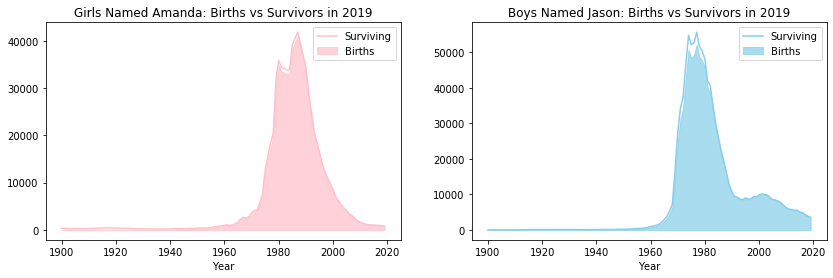

In [47]:
plt.subplots(1,2,figsize=(14,4))
plt.subplot(121)
plot_living_vs_births(name='Amanda',sex='F')
plt.subplot(122)
plot_living_vs_births(name='Jason',sex='M')

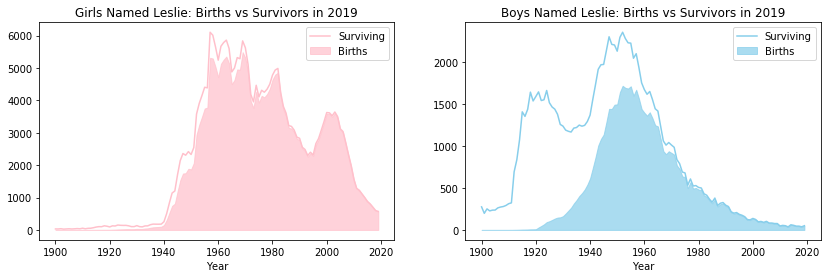

In [48]:
plt.subplots(1,2,figsize=(14,4))
plt.subplot(121)
plot_living_vs_births(name='Leslie',sex='F')
plt.subplot(122)
plot_living_vs_births(name='Leslie',sex='M')

## Bonus Section: Most Popular Baby Names by Year

Here's one more reason that groupby is really useful.  What if you wanted to create a table of the top five baby names for the last decade.  Use the rank function to add another column to df_names.  You might consider the optional arguments for rank. You can even use <tt>head(n)</tt> following the <tt>groupby</tt> to transform the dataframe!

Organize the data as you wish using <tt>unstack</tt>.

In [49]:
df_names['Name rank'] = df_names.groupby(['year','sex']).births.rank(ascending=False)
df_top_names = df_names[(df_names.year > 2009)&(df_names['Name rank'] <= 5)].copy()

In [50]:
df_top_names[['year','Name rank','name','sex']].set_index(['year','sex','Name rank']).unstack([1,2]).sort_values(by='year',ascending=False)

name                                                        \
sex               F                                              M          
Name rank       1.0       2.0       3.0       4.0       5.0    1.0    2.0   
year                                                                        
2019         Olivia      Emma       Ava    Sophia  Isabella   Liam   Noah   
2018           Emma    Olivia       Ava  Isabella    Sophia   Liam   Noah   
2017           Emma    Olivia       Ava  Isabella    Sophia   Liam   Noah   
2016           Emma    Olivia       Ava    Sophia  Isabella   Noah   Liam   
2015           Emma    Olivia    Sophia       Ava  Isabella   Noah   Liam   
2014           Emma    Olivia    Sophia  Isabella       Ava   Noah   Liam   
2013         Sophia      Emma    Olivia  Isabella       Ava   Noah  Jacob   
2012         Sophia      Emma  Isabella    Olivia       Ava  Jacob  Mason   
2011         Sophia  Isabella      Emma    Olivia       Ava  Jacob  Mason   
2010       Isabella    Sophia      Emma    Olivia       Ava  Jacob  Ethan   
2009       Isabella      Emma    Olivia    Sophia       Ava  Jacob  Ethan   

                                        
sex                                     
Name rank      3.0        4.0      5.0  
year                                    
2019        Oliver    William   Elijah  
2018       William      James   Oliver  
2017       William      James    Logan  
2016       William      Mason    James  
2015         Mason      Jacob  William  
2014         Mason      Jacob  William  
2013          Liam      Mason  William  
2012         Ethan       Noah  William  
2011       William     Jayden     Noah  
2010       Michael     Jayden  William  
2009       Michael  Alexander  William

In [51]:
df_top_names[['year','Name rank','name','sex']].set_index(['year','sex','Name rank']).unstack(0)

name                                                    \
year                2009      2010      2011      2012      2013      2014   
sex Name rank                                                                
F   1.0         Isabella  Isabella    Sophia    Sophia    Sophia      Emma   
    2.0             Emma    Sophia  Isabella      Emma      Emma    Olivia   
    3.0           Olivia      Emma      Emma  Isabella    Olivia    Sophia   
    4.0           Sophia    Olivia    Olivia    Olivia  Isabella  Isabella   
    5.0              Ava       Ava       Ava       Ava       Ava       Ava   
M   1.0            Jacob     Jacob     Jacob     Jacob      Noah      Noah   
    2.0            Ethan     Ethan     Mason     Mason     Jacob      Liam   
    3.0          Michael   Michael   William     Ethan      Liam     Mason   
    4.0        Alexander    Jayden    Jayden      Noah     Mason     Jacob   
    5.0          William   William      Noah   William   William   William   

                                                                 
year               2015      2016      2017      2018      2019  
sex Name rank                                                    
F   1.0            Emma      Emma      Emma      Emma    Olivia  
    2.0          Olivia    Olivia    Olivia    Olivia      Emma  
    3.0          Sophia       Ava       Ava       Ava       Ava  
    4.0             Ava    Sophia  Isabella  Isabella    Sophia  
    5.0        Isabella  Isabella    Sophia    Sophia  Isabella  
M   1.0            Noah      Noah      Liam      Liam      Liam  
    2.0            Liam      Liam      Noah      Noah      Noah  
    3.0           Mason   William   William   William    Oliver  
    4.0           Jacob     Mason     James     James   William  
    5.0         William     James     Logan    Oliver    Elijah